# Duckietown NCTU - Tutorial 1: Object Detectors

By Brian Chuang and Nick Wang

## Import Packages

In [1]:
import numpy as np
import scipy as sp
import cv2
import time
from matplotlib import pyplot as plt
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

## Basic OpenCV 

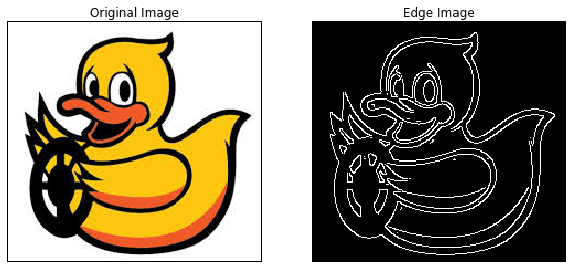

In [2]:
img = cv2.imread('duckietown.jpg')
edges = cv2.Canny(img,100,200)

dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(dst1, cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

## Face Detector

See detail in arg_nctu/wama/face_detector_wama/src/face_detector_wama_node.py

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 78 ms


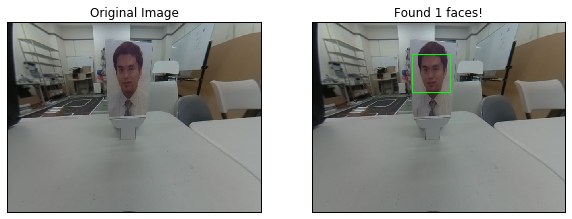

In [4]:
img = cv2.imread('01-tutorial/face.jpg')
vis = cv2.imread('01-tutorial/face.jpg')

faceCascade = cv2.CascadeClassifier('01-tutorial/haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
%time faces = faceCascade.detectMultiScale(gray, scaleFactor=2, minNeighbors=5, minSize=(10, 10), flags = cv2.cv.CV_HAAR_SCALE_IMAGE)

# Visualization
dst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst1 = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
for (x, y, w, h) in faces:
    cv2.rectangle(dst1, (x, y), (x+w, y+h), (0, 255, 0), 2)


plt.subplot(121),plt.imshow(dst, cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst1, cmap = 'brg')
plt.title("Found {0} faces!".format(len(faces))), plt.xticks([]), plt.yticks([])

plt.show()

## Vehicle (Circle Pattern) Detector

See detail in vehicle_detection/src/vehicle_detection_node.py

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 42.1 ms


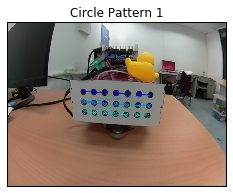

In [6]:
img = cv2.imread('01-tutorial/circle.jpg')

params = cv2.SimpleBlobDetector_Params()
circlepattern_dims = tuple([7, 3])
params.minArea = 10
params.minDistBetweenBlobs = 2
simple_blob_detector = cv2.SimpleBlobDetector(params)

%time (detection, corners) = cv2.findCirclesGrid(img, circlepattern_dims, flags=cv2.CALIB_CB_SYMMETRIC_GRID,blobDetector=simple_blob_detector)

# Visualization
dst = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

cv2.drawChessboardCorners(dst, circlepattern_dims, corners, detection)

plt.subplot(311),plt.imshow(dst, cmap = 'brg')
plt.title('Circle Pattern 1'), plt.xticks([]), plt.yticks([])

plt.show()

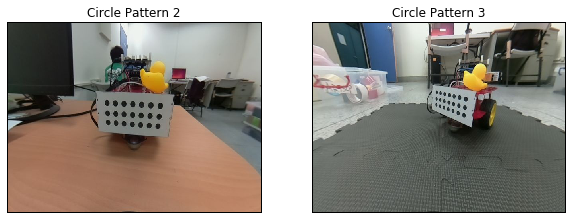

In [7]:
# More Samples
img1 = cv2.imread('01-tutorial/circle_1.jpg')
img2 = cv2.imread('01-tutorial/circle_2.jpg')

dst1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
dst2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

plt.subplot(121),plt.imshow(dst1, cmap = 'brg')
plt.title('Circle Pattern 2'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst2, cmap = 'brg')
plt.title('Circle Pattern 3'), plt.xticks([]), plt.yticks([])

plt.show()

## Duckie Detector

See detail in src/mdoap/src/static_object_detector_node.py

You may need to change the high/low color thresholds

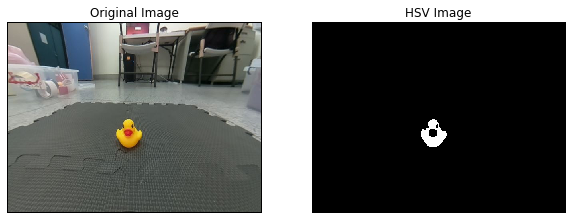

In [8]:
CONE = [np.array(x, np.uint8) for x in [[0,80,80], [22, 255,255]] ]
DUCK = [np.array(x, np.uint8) for x in [[15,100,150], [35, 255, 255]] ]

img = cv2.imread('01-tutorial/duckie_1.jpg')
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
frame_threshed = cv2.inRange(hsv_img, DUCK[0], DUCK[1])
ret,thresh = cv2.threshold(frame_threshed,15,255,0)
    
dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(dst1, cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(frame_threshed, cmap = 'gray')
plt.title('HSV Image'), plt.xticks([]), plt.yticks([])

plt.show()

### function to get filtered contours

In [9]:
def get_filtered_contours(img, contour_type):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    if contour_type == "CONE":
        frame_threshed = cv2.inRange(hsv_img, CONE[0], CONE[1])
        ret,thresh = cv2.threshold(frame_threshed,22,255,0)
    elif contour_type == "DUCK_COLOR":
        frame_threshed = cv2.inRange(hsv_img, DUCK[0], DUCK[1])
        ret,thresh = cv2.threshold(frame_threshed,25,255,0)
    elif contour_type == "DUCK_CANNY":
        frame_threshed = cv2.inRange(hsv_img, DUCK[0], DUCK[1])
        frame_threshed = cv2.adaptiveThreshold(frame_threshed,255,\
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,2)
        thresh = cv2.Canny(frame_threshed, 100,200)
    else:
        return
    
    filtered_contours = []

    contours, hierarchy = cv2.findContours(\
            thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    contour_area = [ (cv2.contourArea(c), (c) ) for c in contours]
    contour_area = sorted(contour_area,reverse=True, key=lambda x: x[0])

    height,width = img.shape[:2]
    for (area,(cnt)) in contour_area:
    # plot box around contour
        x,y,w,h = cv2.boundingRect(cnt)
        box = (x,y,w,h)
        d =  0.5*(x-width/2)**2 + (y-height)**2
        if not(h>15 and w >10 and h<200 and w<200 and d < 120000):
            continue
        if contour_type == "DUCK_CANNY":
            continue
        if contour_type =="DUCK_COLOR": # extra filtering to remove lines
            if not(h>25 and w>25):
                continue
            if d>90000:
                if not(h>35 and w>35):
                    continue
            if cv2.contourArea(cnt)==0:
                continue
            val = cv2.arcLength(cnt,True)**2/ cv2.contourArea(cnt)
            if val > 35: continue
            rect = cv2.minAreaRect(cnt)
            ctr, sides, deg = rect
            val  = 0.5*cv2.arcLength(cnt,True) / (w**2+h**2)**0.5
            if val < 1.12: continue
            #if area > 1000: continue

        mask = np.zeros(thresh.shape,np.uint8)
        cv2.drawContours(mask,[cnt],0,255,-1)
        mean_val = cv2.mean(img,mask = mask)
        aspect_ratio = float(w)/h
        filtered_contours.append( (cnt, box, d, aspect_ratio, mean_val) )
    
    return filtered_contours


### Let's detect duckie!

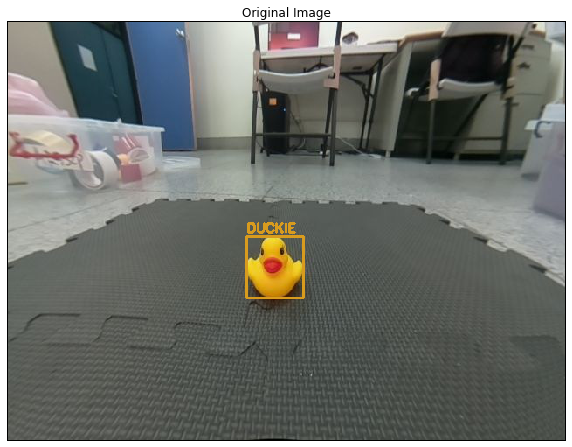

In [10]:
img = cv2.imread('01-tutorial/duckie_1.jpg')

duck_contours = get_filtered_contours(img, "DUCK_COLOR")

for (cnt, box, ds, aspect_ratio, mean_color)  in duck_contours:
    # plot box around contour
    x,y,w,h = box
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, "DUCKIE", (x,y-5), font, 0.5, mean_color, 2)
    cv2.rectangle(img,(x,y),(x+w,y+h), mean_color,2)

dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(111),plt.imshow(dst1, cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.show()

## Parking Space (Blue Region) Detector

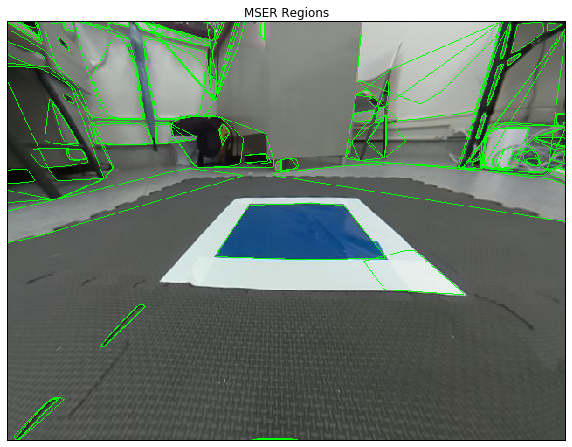

In [11]:
img = cv2.imread('01-tutorial/park.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

vis = dst1.copy()
mser = cv2.MSER()
regions = mser.detect(gray, None)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0))

plt.subplot(111),plt.imshow(vis,cmap = 'gray')
plt.title('MSER Regions'), plt.xticks([]), plt.yticks([])

plt.show()

## Cockroach Detector

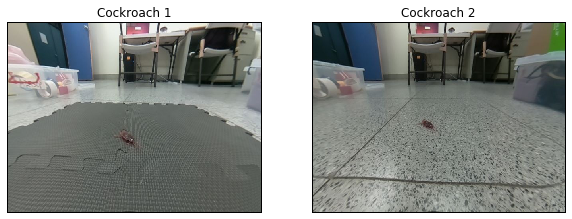

In [12]:
img = cv2.imread('01-tutorial/cockroach_1.jpg')
img1 = cv2.imread('01-tutorial/cockroach_2.jpg')

dst = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
dst1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(dst, cmap = 'brg')
plt.title('Cockroach 1'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst1,cmap = 'brg')
plt.title('Cockroach 2'), plt.xticks([]), plt.yticks([])

plt.show()

## Stop Line Detector

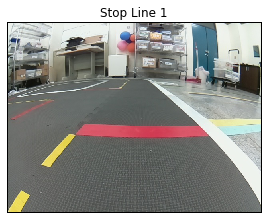

In [13]:
img = cv2.imread('01-tutorial/stop.jpg')

dst = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(dst, cmap = 'brg')
plt.title('Stop Line 1'), plt.xticks([]), plt.yticks([])

plt.show()